# HW01

# 3 High-dimensional data

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from matplotlib import pyplot as plt

import torch
from torch.nn.modules import loss
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset

import torch.utils.data as data
from tqdm.auto import tqdm

In [0]:
torch.manual_seed(0)
DEVICE = torch.device("cuda")

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, stride, padding):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, stride, padding)
        self.mask = torch.ones(self.weight.shape).to(DEVICE)
        self.mask[:, :, self.weight.shape[2] // 2, self.weight.shape[3] // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, self.weight.shape[2] // 2 + 1:] = 0

    def forward(self, input):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(input)

In [0]:
class MaskResBlock(nn.Module):
    def __init__(self):
        super(MaskResBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(64, 32, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            MaskedConv2d('B', 32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 1),
            nn.BatchNorm2d(64)
        )

    def forward(self, input):
        return self.layers(input) + input

In [0]:
class PixelCNN(nn.Module):
    def __init__(self):
        super(PixelCNN, self).__init__()

        self.layers = nn.Sequential(
            MaskedConv2d('A', 3, 2 * 32, 7, 1, 3),
            MaskResBlock(), MaskResBlock(), MaskResBlock(), MaskResBlock(), MaskResBlock(), MaskResBlock(),
            MaskResBlock(), MaskResBlock(), MaskResBlock(), MaskResBlock(), MaskResBlock(), MaskResBlock(),
            nn.ReLU(),
            nn.Conv2d(2 * 32, 2 * 32, 1),
            nn.BatchNorm2d(2 * 32),
            nn.ReLU(),
            nn.Conv2d(2 * 32, 3 * 4, 1)
        )

    def forward(self, input):
        output = self.layers(input.float())
        output = output.reshape(input.shape[0], input.shape[1], 4, input.shape[2], input.shape[3])
        output = output.permute(0, 1, 3, 4, 2)
        return output

In [0]:
def Loss(output, input):
  output = F.softmax(output, dim=-1)
  input = F.one_hot(input, 4).float()
  output = (output * input).sum(dim=-1)
  loss = -torch.log(output + 1e-9)
  return loss.mean()

In [0]:
def train(model, loss_function, optimizer, epochs):
    losses_train = []
    losses_val = []
    for i in tqdm(range(epochs)):
        losses = []
        model.train()
        for batch in train_loader:
            batch = batch.to(DEVICE)
            optimizer.zero_grad()
            output = model(batch)
            loss = loss_function(output, batch)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        losses_train.append(np.array(losses).mean())

        losses = []
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(DEVICE)
                output = model(batch)
                loss = loss_function(output, batch)
                losses.append(loss.item())
        losses_val.append(np.array(losses).mean())

        print("Epoch " + str(i))
    return losses_train, losses_val

In [0]:
with open('drive/My Drive/mnist-hw1.pkl', 'rb') as dataset_file:
    dataset = pickle.load(dataset_file)

x_train = dataset['train']
x_val = dataset['test']

In [0]:
batch_size = 128

x_train = torch.LongTensor(x_train)
x_val = torch.LongTensor(x_val)
x_train = x_train.permute(0, 3, 1, 2)
x_val = x_val.permute(0, 3, 1, 2)

train_loader = data.DataLoader(dataset=x_train, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(dataset=x_val, batch_size=batch_size, shuffle=False)

In [0]:
def plot_losses(losses_train, losses_val):
    plt.plot(range(epochs), losses_train, label="train")
    plt.plot(range(epochs), losses_val, label="val")
    plt.legend()
    plt.show()

In [0]:
def sample_images(model):
    samples = np.zeros((100, 28, 28, 3), dtype=np.uint8)
    with torch.no_grad():
        for y in tqdm(range(28)):
            for x in range(28):
                for c in range(3):
                    input = collate_fn(samples).to(DEVICE)
                    output = model(input)
                    output = F.softmax(output, dim=4).cpu().numpy()
                    for i in range(100):
                        samples[i, y, x, c] = np.random.choice(4, p=output[i, c, y, x])
    samples *= 85
    
    n = int(np.ceil(np.sqrt(100)))
    f, axarr = plt.subplots(n, n)
    f.set_figheight(15)
    f.set_figwidth(15)
    for i, img in enumerate(samples):
        axarr[i // n, i % n].imshow(img)
        axarr[i // n, i % n].axis('off')
    plt.show()


In [0]:
epochs = 50
model = PixelCNN()
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), 0.001, weight_decay=0)

In [51]:
train_losses, val_losses = train(model, Loss, optimizer, epochs)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49


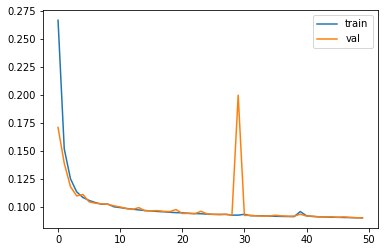

In [52]:
plot_losses(train_losses, val_losses)

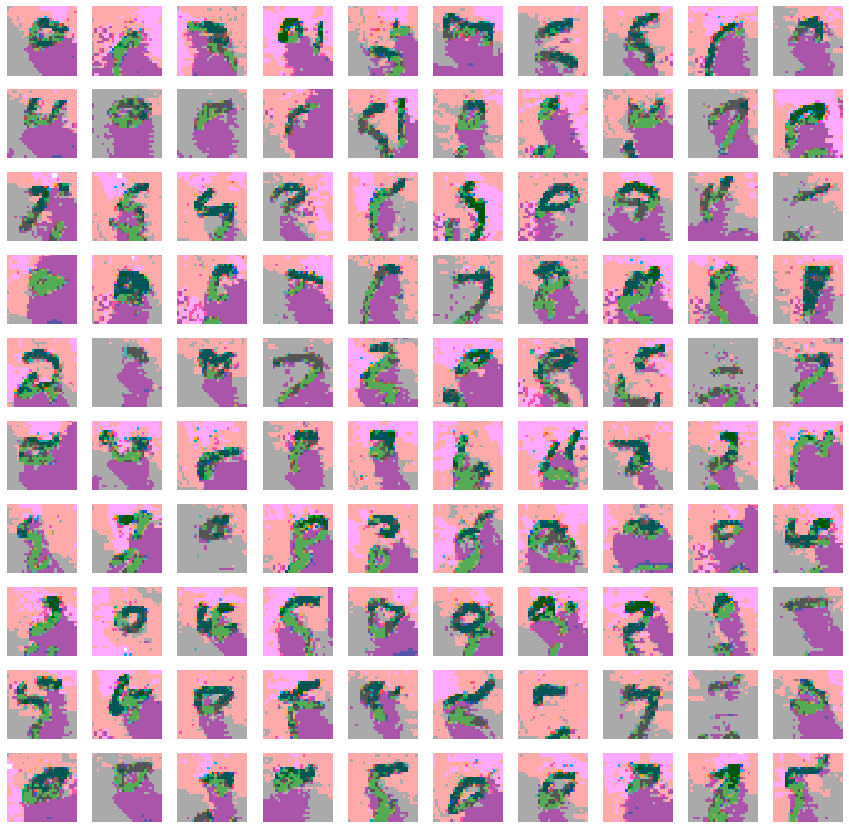

In [57]:
model.eval()
sample_images(model)